In [1]:
import numpy as np
from scipy.ndimage import laplace
import matplotlib.pyplot as plt

In [2]:
edt = np.load('results/edt.npy')
nt,nx,ny = edt.shape

In [3]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
h = maxy - miny
w = int(w//2) * 2
h = int(h//2) * 2

print(w,h)
pad = 256

crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

448 440
(406, 960, 952)


In [4]:
print(crop_edt.shape)
crop_edt = crop_edt[100:,::16,::16]
print(crop_edt.shape)
nt,nx,ny = crop_edt.shape

(406, 960, 952)
(306, 60, 60)


In [5]:
u0 = np.zeros((nx,ny)) + 1
def dudt(u, t, tmask, phi, kappa, gamma, dx):
    du = np.zeros((nx,ny))
    du[tmask] += phi * (t < 6 * 60 * 60) # * np.exp(-t * 1e-6)
    u = u.reshape((nx,ny))
    delu = laplace(u, mode='nearest')
    du += kappa * delu / dx / dx
    du[tmask] -= gamma * u[tmask] * (t < 6 * 60 * 60)
    return du.ravel()

In [6]:
p0 = np.zeros((nx,ny,3)) + 1 # np.random.uniform(size=(nx,ny,3))
def dpdt(p, t, tmask, alpha0, alpha1, alpha2, gamma):
    p = p.reshape((nx,ny,3))
    dpdt = np.zeros_like(p)
    dpdt[:,:,0] = alpha0 - gamma * p[:,:,0]
    dpdt[:,:,1] = alpha1 - gamma * p[:,:,1]
    dpdt[:,:,2] = alpha2 - gamma * p[:,:,2]
    for c in range(3):
        cdpdt = dpdt[:,:,c]
        cdpdt[tmask==0] = 0
        dpdt[:,:,c] = cdpdt
    return dpdt.ravel()


In [67]:
from scipy.integrate import odeint

phi = 0
kappa = 1e-13
gamma = 1e-2
dx = 16e-6
dt = 30
ts = np.arange(0, np.floor(48 * 60 * 60 // dt))
nt = len(ts)
print(nt)
u = np.zeros((nt+1,nx,ny))
u[0,:,:] = u0
p = np.zeros((nt+1,nx,ny,3))
p[0,:,:,:] = p0
mask = np.zeros((nt+1,nx,ny))
mask[0,:,:] = crop_edt[0,:,:]>0
for ti in range(nt):
    t = int(ts[ti] * dt)
    tmask = crop_edt[0,:,:] # crop_edt[int(t / 60 / 10),:,:]
    du = dudt(u[ti,:,:], t, tmask>0,phi,kappa,gamma,dx)
    u[ti+1,:,:] = u[ti,:,:] + dt * du.reshape(nx,ny)
    alpha0 = 100 * u[ti,:,:] + 1
    alpha1 = 1 * u[ti,:,:] + 1
    alpha2 = 1 * u[ti,:,:] + 1
    dp = dpdt(p[ti,:,:,:], t, tmask>0, alpha0, alpha1, alpha2, np.log(2)/(6 * 60 * 60))
    p[ti+1,:,:,:] = p[ti,:,:,:] + dt * dp.reshape(nx,ny,3)
    mask[ti+1,:,:] = tmask
#u = u.reshape((200,nx,ny))

5760


In [68]:
umask = np.zeros_like(u) + np.nan
umask[mask>0] = u[mask>0]

pmask = np.zeros_like(p) + np.nan
for c in range(3):
    cp = p[:,:,:,c]
    cpmask = pmask[:,:,:,c]
    cpmask[mask>0] = cp[mask>0]
    pmask[:,:,:,c] = cpmask

Text(0, 0.5, 'Position (pixels)')

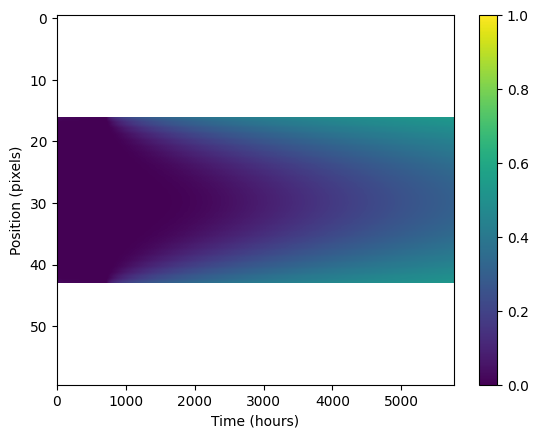

In [69]:
plt.imshow(umask[:,int(nx//2),:].transpose(), aspect='auto') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()
#plt.contour(u[:,int(nx//2),:].transpose(), [0.025], linestyle='w--')
plt.xlabel('Time (hours)')
plt.ylabel('Position (pixels)')

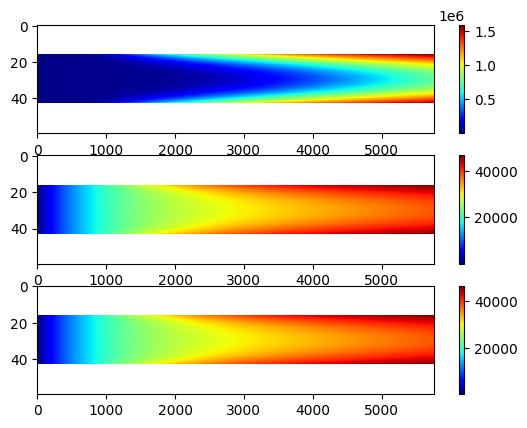

In [70]:
plt.subplot(3,1,1)
plt.imshow(pmask[:,int(nx//2),:,0].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(pmask[:,int(nx//2),:,1].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(pmask[:,int(nx//2),:,2].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

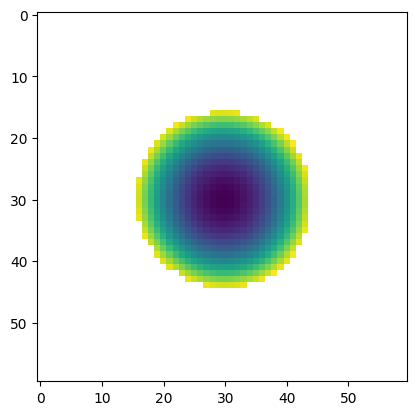

In [71]:
plt.imshow(pmask[4000,:,:,1])

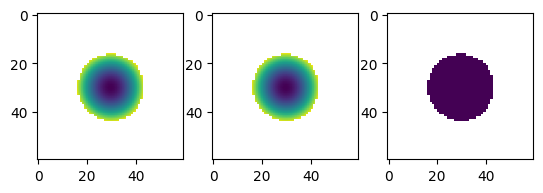

In [72]:
rho_01 = pmask[:,:,:,0] / pmask[:,:,:,1]
rho_02 = pmask[:,:,:,0] / pmask[:,:,:,2]
rho_12 = pmask[:,:,:,1] / pmask[:,:,:,2]
plt.subplot(1,3,1)
plt.imshow(rho_01[4000,:,:])
plt.subplot(1,3,2)
plt.imshow(rho_02[4000,:,:])
plt.subplot(1,3,3)
plt.imshow(rho_12[4000,:,:])

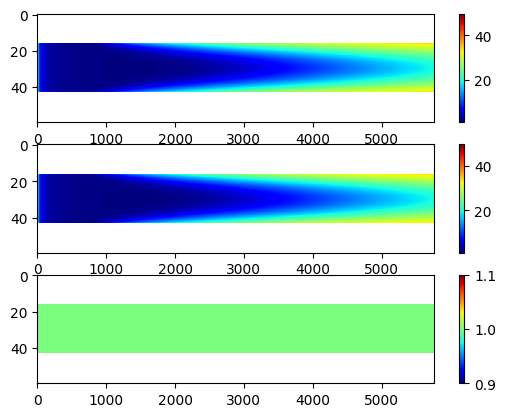

In [73]:
plt.subplot(3,1,1)
plt.imshow(rho_01[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(rho_02[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

plt.subplot(3,1,3)
plt.imshow(rho_12[:,int(nx//2),:].transpose(), aspect='auto', cmap='jet') #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

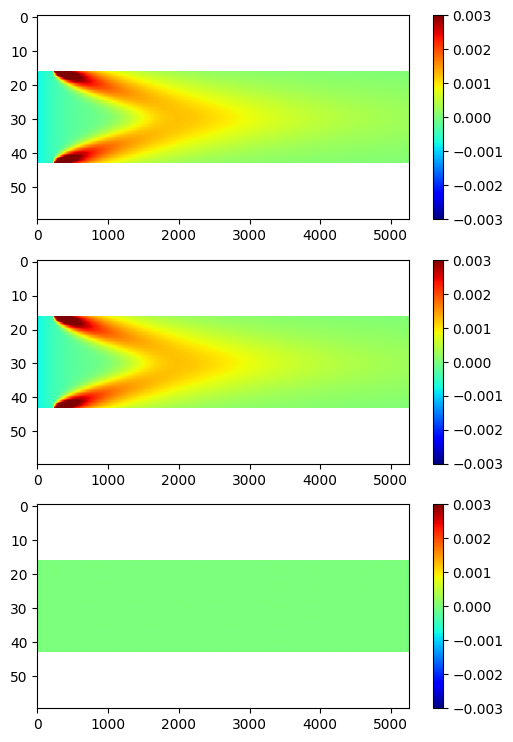

In [74]:
from scipy.signal import savgol_filter

plt.figure(figsize=(6,9))

lrho_01 = np.log(rho_01)
dslrho_01 = savgol_filter(lrho_01, 11, 3, deriv=1, axis=0)

plt.subplot(3,1,1)
plt.imshow(dslrho_01[500:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.003, vmax=0.003) 
#, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

lrho_02 = np.log(rho_02)
dslrho_02 = savgol_filter(lrho_02, 11, 3, deriv=1, axis=0)

plt.subplot(3,1,2)
plt.imshow(dslrho_02[500:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.003, vmax=0.003) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

lrho_12 = np.log(rho_12)
dslrho_12 = savgol_filter(lrho_12, 11, 3, deriv=1, axis=0)

plt.subplot(3,1,3)
plt.imshow(dslrho_12[500:,int(nx//2),:].transpose(), aspect='auto', cmap='jet', vmin=-0.003, vmax=0.003) #, extent=[0, 16 * ny, dt * ts[-1] / 60 / 60, 0])
plt.colorbar()

In [75]:
from scipy.signal import find_peaks

pks = np.zeros((nx,ny))
for x in range(nx):
    for y in range(ny):
        pk = find_peaks(dslrho_01[:,x,y])[0]
        if len(pk)>0:
            pks[x,y] = pk[0]

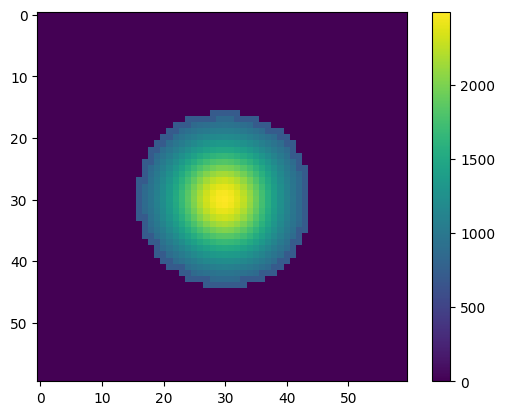

In [76]:
plt.imshow(pks)
plt.colorbar()

In [77]:
edt0 = crop_edt[0,:,:]
pkdiff = pks[edt0==edt0.max()].mean() - pks[edt0==edt0[edt0>0].min()].mean()
tdiff = pkdiff * dt / 60 / 60
tdiff

14.808333333333334

In [78]:
speed = edt0.max() / tdiff
speed

14.993992106589433

In [79]:
edt0.max()

222.03603311174518